Evaluation of our Framework

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import warnings

# --- 1. IPython Magic: Autoreload ---
# This tells the notebook to automatically reload modules
# when the .py files (like LinearMetaModel.py) are changed.
%load_ext autoreload
%autoreload 2
print("Autoreload enabled.")

# --- 2. Setup Paths ---
# Get the current directory of the notebook (e.g., .../Bachelor-Thesis/experiments/framework_eval)
current_dir = os.getcwd()
print(f"Current notebook directory: {current_dir}")

# Go UP TWO levels to the project root (e.g., .../Bachelor-Thesis)
project_root = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir))
print(f"Calculated project root: {project_root}")

# Define the correct path to the 'src' folder (e.g., .../Bachelor-Thesis/src)
src_path = os.path.join(project_root, 'src')
print(f"Target 'src' directory: {src_path}")

# Add the correct 'src' path
if src_path not in sys.path:
    sys.path.append(src_path)
    print(f"Added to path: {src_path}")
else:
    print(f"Path already exists: {src_path}")

# --- 3. Try imports ---
# This cell should now work, BUT only if you do Part 2 below
try:
    from src.ExplainableTreeEnsemble import ExplainableTreeEnsemble
    from src.BasicMetaModel import BasicMetaModel
    from src.LinearMetaModel import LinearMetaModel
    print("\nImports loaded successfully.")
except ModuleNotFoundError as e:
    print(f"\nImport Error: {e}")
    print(f"Could not find modules at: {src_path}")
    print(">>> IF THIS FAILED, PLEASE DO PART 2 <<<")

warnings.filterwarnings('ignore')

Autoreload enabled.
Current notebook directory: /home/people/amine/workspace/Bachelor-thesis/experiments/framework_eval
Calculated project root: /home/people/amine/workspace/Bachelor-thesis
Target 'src' directory: /home/people/amine/workspace/Bachelor-thesis/src
Added to path: /home/people/amine/workspace/Bachelor-thesis/src


/home/people/amine/workspace/Bachelor-thesis/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Imports loaded successfully.


In [67]:
# --- 2. Define Experiment Parameters ---
DATASET_NAME = "3droad"
  # 200 trees -> 60 trees (30%)

# Set dynamic correlation threshold
if DATASET_NAME == "bike":
    CORR_THRESH_STAGE2 = 0.99
elif DATASET_NAME == "3droad":
    CORR_THRESH_STAGE2 = 0.9
elif DATASET_NAME == "slice":
    CORR_THRESH_STAGE2 = 0.95
else:
    CORR_THRESH_STAGE2 = 0.9

# This is the file we will append to
output_file = "framework_analysis_results.csv"

print(f"--- Starting Experiment ---")
print(f"Dataset: {DATASET_NAME}")

print(f"Stage 2 Corr Thresh: {CORR_THRESH_STAGE2}")
print(f"Results will be saved to: {output_file}")

--- Starting Experiment ---
Dataset: 3droad
Stage 2 Corr Thresh: 0.9
Results will be saved to: framework_analysis_results.csv


In [68]:
# --- 3. Step 1: Full Ensemble (Baseline) ---
print("\n[Step 1/3] Training Full Ensemble...")

# Assumes Cell 2 has been run
workflow = ExplainableTreeEnsemble(data_type="regression", dataset_name=DATASET_NAME)
workflow.train_base_trees()

# FIX: We manually call _evaluate() to get the MSE
mse_full, _ , _ , _ , _ ,  _ = workflow._evaluate()
trees_full = workflow.n_trees

# Get n_samples and n_features from the workflow
n_samples = workflow.n_samples
n_features = workflow.n_features

print(f"Full Ensemble: {mse_full:.4f} MSE, {trees_full} Trees")
print(f"Dataset Stats: {n_samples} samples, {n_features} features")
print("\n'workflow' object created.")


[Step 1/3] Training Full Ensemble...
3droad dataset, N=434874, d=3
-------------creating the base Trees-------------- 
full ensemble mse 178.2536283830905
Full Ensemble: 178.2536 MSE, 200 Trees
Dataset Stats: 347899 samples, 3 features

'workflow' object created.


In [69]:
# --- 4. Step 2: Stage 1 Pruning (SHAP Rank) ---
print("\n[Step 2/3] Running Stage 1 (SHAP Rank Pruning)...")
KEEP_RATIO_STAGE1 = 0.3
try:
    model_stage1 = BasicMetaModel(keep_ratio=KEEP_RATIO_STAGE1)
    model_stage1.attach_to(workflow)
    model_stage1.train() 

    mse_stage1, _ = model_stage1.evaluate() 
    trees_stage1 = len(model_stage1.pruned_trees)

    print(f"After Stage 1: {mse_stage1:.4f} MSE, {trees_stage1} Trees")
    print("\n'model_stage1' object created.")
    
except NameError as e:
    print(f"Error: Make sure you have run Cell 3 first! (Details: {e})")


[Step 2/3] Running Stage 1 (SHAP Rank Pruning)...
=== Stage 1: Training model and pruning by SHAP (keep top 30.0%) ===
Pre-Pruned ensemble MSE (Weighted): 153.53825924167577
After Stage 1: 153.5383 MSE, 60 Trees

'model_stage1' object created.


--- Visualizing model_stage1 Results ---
Stage 1 kept 60 trees. Indices: [ 42  23  40 199 145]...


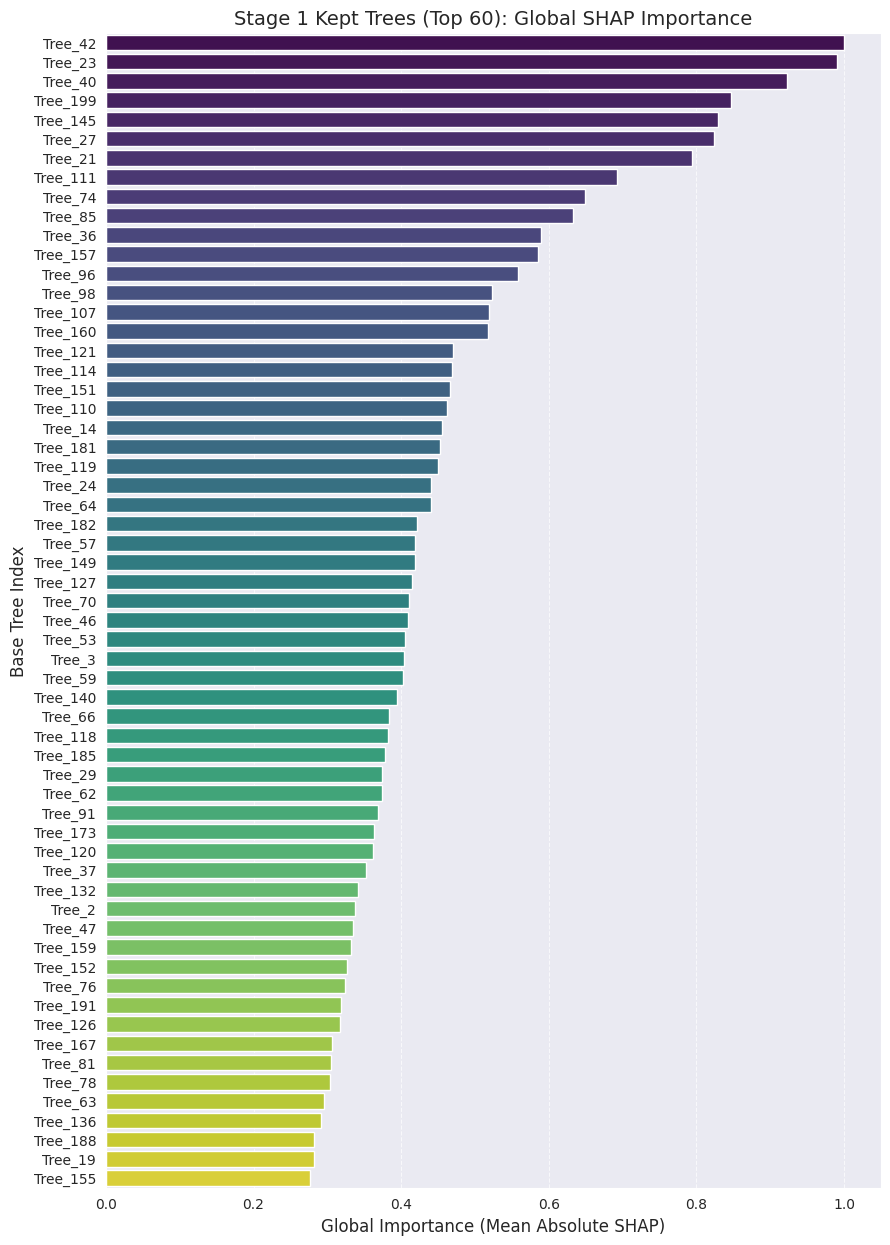

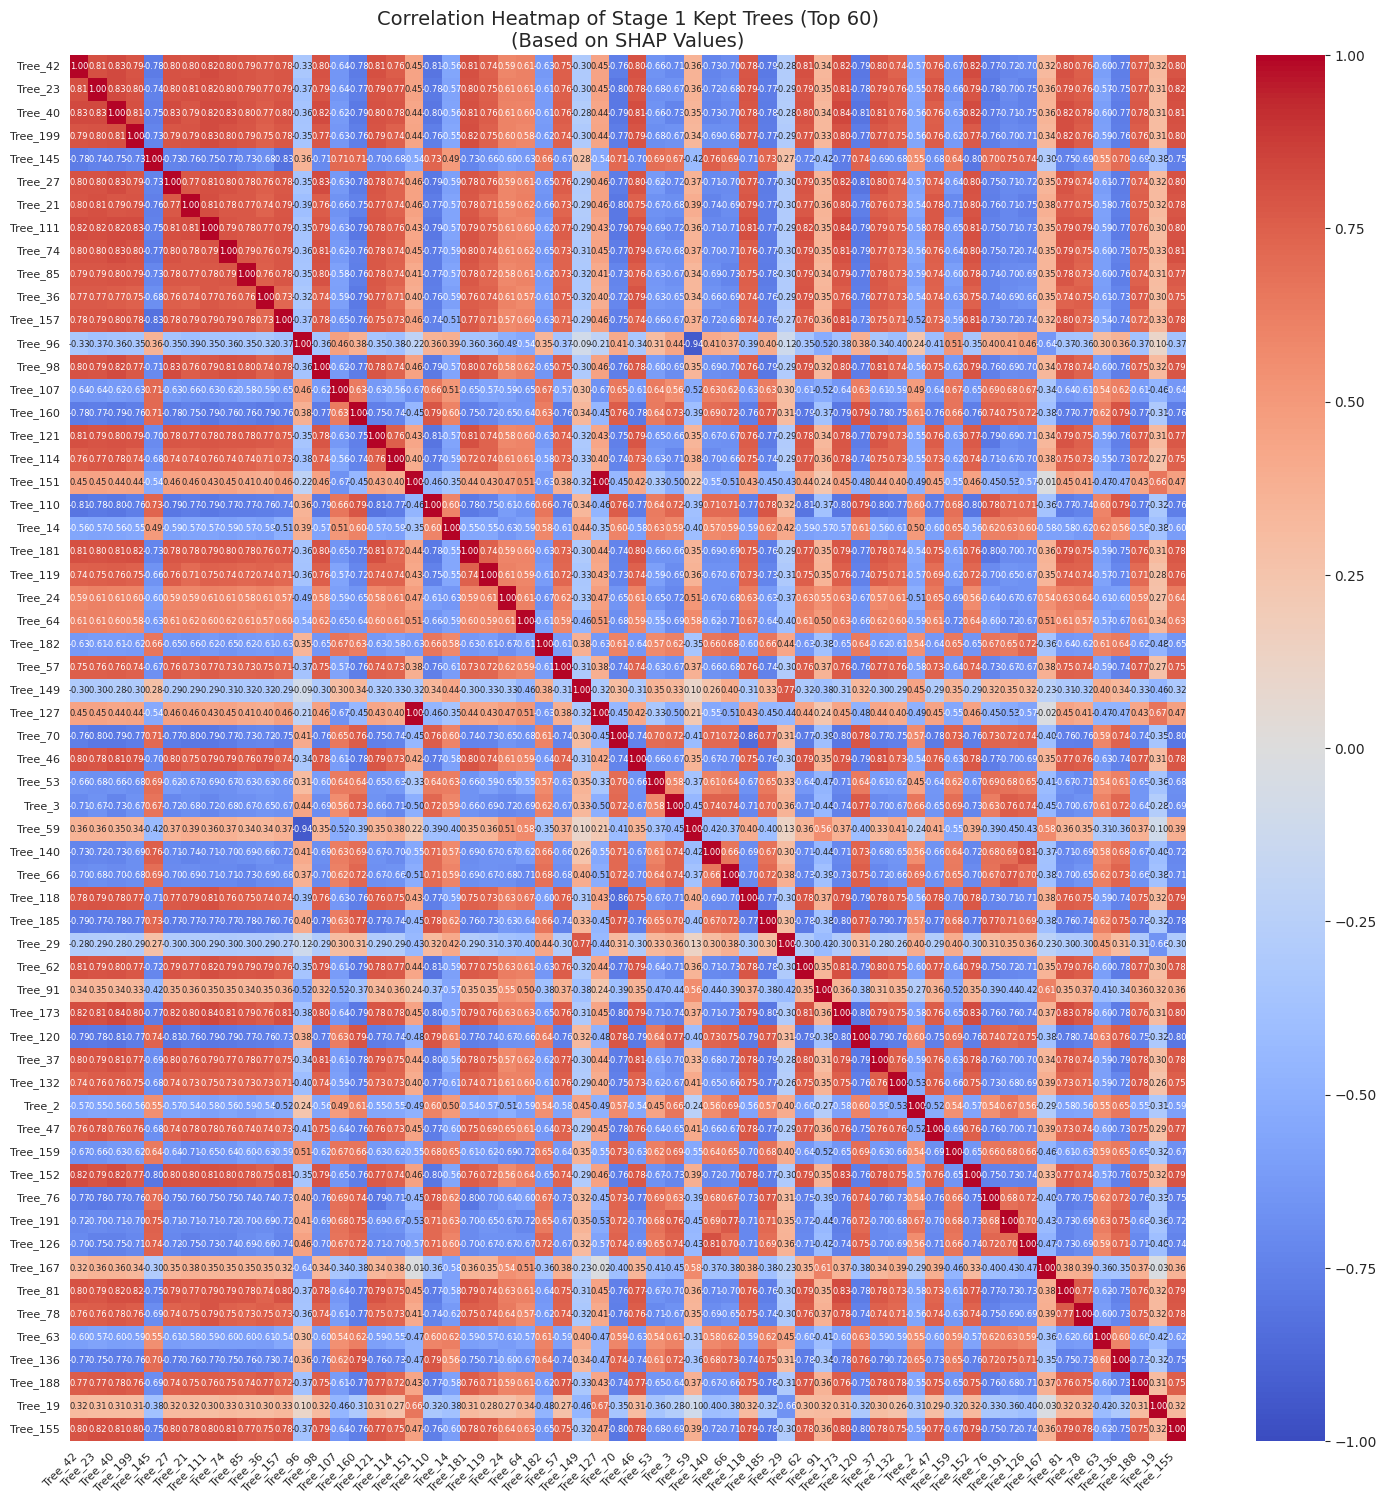

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

print("--- Visualizing model_stage1 Results ---")

# --- 1. Get the indices of the trees kept after Stage 1 ---

# Get the global importance (mean abs SHAP) for ALL trees
tree_importance = model_stage1.tree_importance

# Calculate 'k' (number of trees to keep) based on the model's keep_ratio
k = max(1, int(len(tree_importance) * model_stage1.keep_ratio))

# Get the indices of the top 'k' trees
# These are the original indices from the 0-199 range
top_indices = np.argsort(tree_importance)[-k:][::-1]

# Create feature names for these 'k' trees
kept_feature_names = [f"Tree_{i}" for i in top_indices]

print(f"Stage 1 kept {k} trees. Indices: {top_indices[:5]}...")

# --- 2. Plot 1: Global SHAP Importance (Bar Plot) ---

# Get the importance scores for only the trees we kept
kept_importances = tree_importance[top_indices]

# Plot
plt.figure(figsize=(10, max(8, k * 0.25))) # Dynamic height
sns.barplot(x=kept_importances, y=kept_feature_names, orient='h', palette='viridis')
plt.title(f"Stage 1 Kept Trees (Top {k}): Global SHAP Importance", fontsize=14)
plt.xlabel("Global Importance (Mean Absolute SHAP)", fontsize=12)
plt.ylabel("Base Tree Index", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# --- 3. Plot 2: Correlation Heatmap (Based on SHAP Values) ---

# Get the raw SHAP values (all trees)
shap_values_raw = model_stage1.shap_values

# Handle multiclass (ndim == 3) vs. regression (ndim == 2)
# We use mean(abs(SHAP)) for correlation in multiclass
if shap_values_raw.ndim == 3:
    corr_shap_values = np.mean(np.abs(shap_values_raw), axis=2)
else:
    corr_shap_values = shap_values_raw

# Filter SHAP values to include only the 'k' kept trees
kept_corr_shap = corr_shap_values[:, top_indices]

# Create a DataFrame for easy correlation calculation
df_shap = pd.DataFrame(kept_corr_shap, columns=kept_feature_names)

# Calculate the correlation matrix
corr_matrix = df_shap.corr()

# Plot
plt.figure(figsize=(max(12, k * 0.3), max(10, k * 0.3))) # Dynamic size
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',
            annot_kws={"size": 6}, # Smaller annotations
            vmin=-1, vmax=1)
plt.title(f"Correlation Heatmap of Stage 1 Kept Trees (Top {k})\n(Based on SHAP Values)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

In [92]:

print("\n[Step 3/3] Running Stage 2 (HRP Optimization Pruning)...")

try:
    model_stage2 = LinearMetaModel()
    model_stage2.attach_to(workflow) 
    model_stage2.train(pruned_trees_list=model_stage1.pruned_trees) 
    model_stage2.prune(corr_thresh=CORR_THRESH_STAGE2) 

    mse_stage2, _ = model_stage2.evaluate() 
    trees_stage2 = len(model_stage2.pruned_trees)

    print(f"After Stage 2: {mse_stage2:.4f} MSE, {trees_stage2} Trees")
    print("\n'model_stage2' object created.")

except NameError as e:
    print(f"Error: Make sure you have run Cell 4 first! (Details: {e})")


[Step 3/3] Running Stage 2 (HRP Optimization Pruning)...
[INFO] Training LinearMetaModel on 60 pruned trees...
 Lambda prune :  95.9954605102539
 Lambda div :  95.9954605102539
Epoch    0 | Total Loss: 673.9785 | MSE Loss: 336.9893 | Prune Loss: 3.5105 | Div Loss: 0.033136
Epoch   20 | Total Loss: 426.2628 | MSE Loss: 111.9829 | Prune Loss: 3.2739 | Div Loss: 0.042318
Epoch   40 | Total Loss: 393.5694 | MSE Loss: 108.5510 | Prune Loss: 2.9691 | Div Loss: 0.055050
Epoch   60 | Total Loss: 357.5336 | MSE Loss: 105.9975 | Prune Loss: 2.6203 | Div Loss: 0.077628
Epoch   80 | Total Loss: 340.8859 | MSE Loss: 103.6788 | Prune Loss: 2.4710 | Div Loss: 0.096629
Epoch  100 | Total Loss: 327.0972 | MSE Loss: 101.9892 | Prune Loss: 2.3450 | Div Loss: 0.111992
Epoch  120 | Total Loss: 309.4812 | MSE Loss: 99.0083 | Prune Loss: 2.1925 | Div Loss: 0.135534
Epoch  140 | Total Loss: 292.0876 | MSE Loss: 100.6172 | Prune Loss: 1.9946 | Div Loss: 0.188705
Epoch  160 | Total Loss: 278.4830 | MSE Loss: 1

--- Visualizing 'Pre-Prune' state of 'LinearMetaModel' ---
Plotting 60 candidate trees that were the *input* to this model.


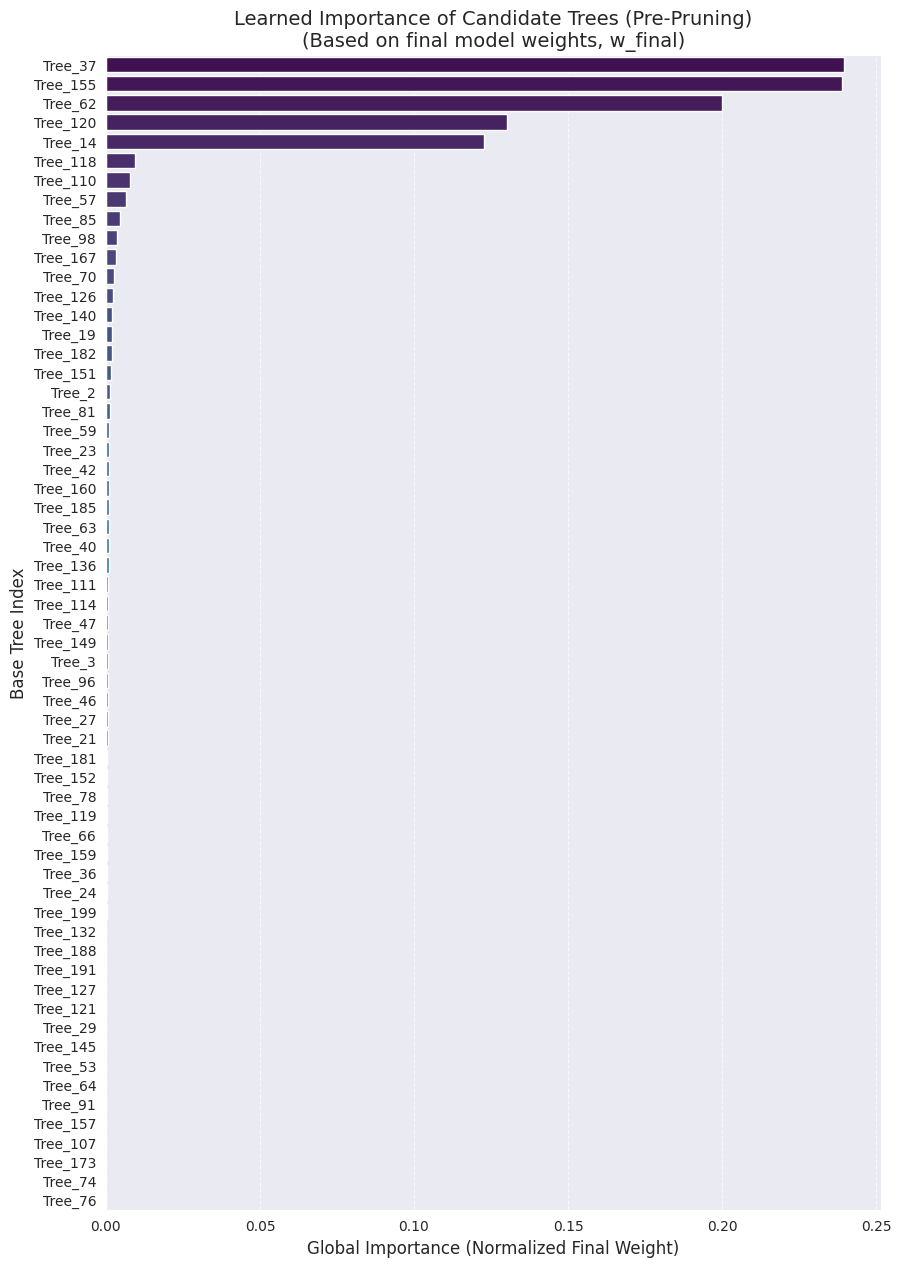


--- Plotting Meta-Feature Correlation for Top 20 Candidate Trees ---


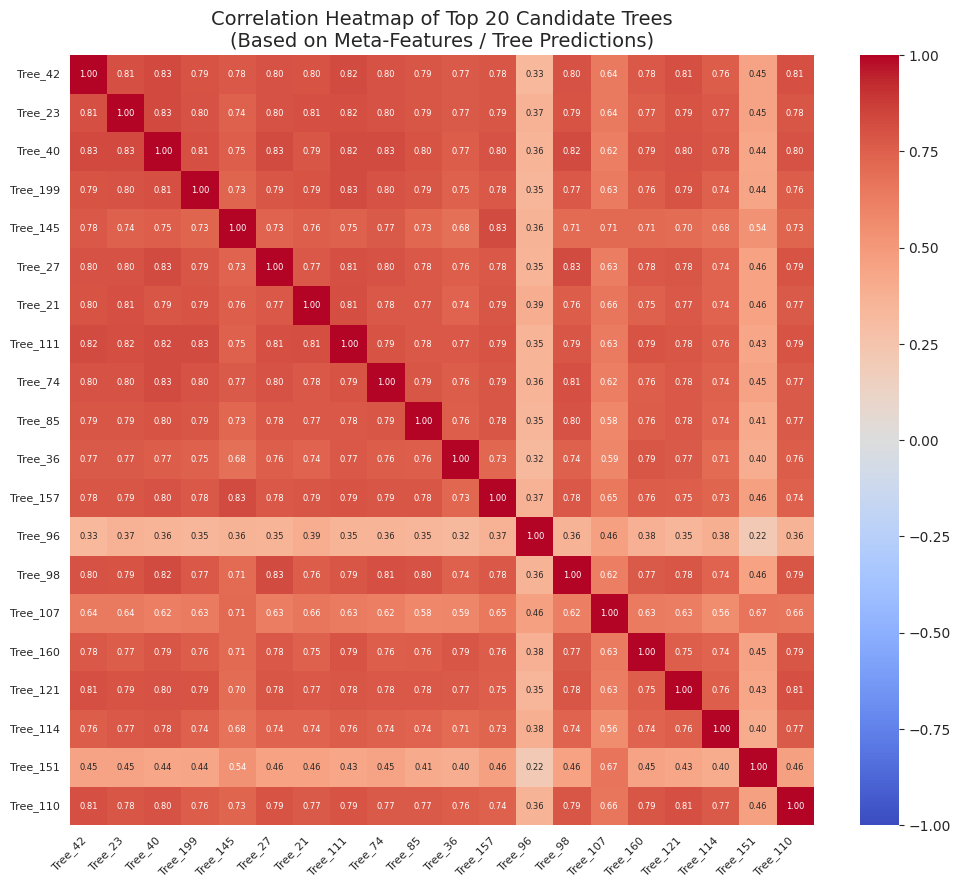

In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# --- ASSUMPTION ---
# model_stage1: The BasicMetaModel (keep_ratio=0.2)
# model_stage2: The LinearMetaModel that has JUST been .train()ed
# --------------------

print(f"--- Visualizing 'Pre-Prune' state of '{type(model_stage2).__name__}' ---")

# --- 1. Get the Names of the 40 "Candidate" Trees ---
# Get the names of ALL 40 candidate trees, sorted by Stage 1 importance
k_stage1 = max(1, int(len(model_stage1.tree_importance) * model_stage1.keep_ratio))

top_indices_stage1 = np.argsort(model_stage1.tree_importance)[-k_stage1:][::-1]
stage1_names = [f"Tree_{i}" for i in top_indices_stage1]

print(f"Plotting {k_stage1} candidate trees that were the *input* to this model.")

# --- 2. Plot 1: Global Importance (from self.w_final) ---
# This IS the learned importance, as w_final is the result
# of optimizing the SHAP-based losses.
#
final_weights = model_stage2.w_final

if final_weights is None:
    print("Error: 'model_stage2.w_final' is None. Did you call .train()?")
else:
    # Sort by importance (highest w_final first)
    sort_idx = np.argsort(final_weights)[::-1]
    final_weights_sorted = final_weights[sort_idx]
    final_names_sorted = [stage1_names[i] for i in sort_idx]

    # --- COLOR CHANGED ---
    # Using 'viridis' to match your Stage 1 plot
    plt.figure(figsize=(10, max(8, k_stage1 * 0.25)))
    sns.barplot(x=final_weights_sorted, y=final_names_sorted, orient='h', palette='viridis')
    plt.title(f"Learned Importance of Candidate Trees (Pre-Pruning)\n(Based on final model weights, w_final)", fontsize=14)
    plt.xlabel("Global Importance (Normalized Final Weight)", fontsize=12)
    plt.ylabel("Base Tree Index", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# --- 3. Plot 2: Correlation of Top 20 Candidate Trees (Based on Meta-Features) ---
# This shows the correlation of the *tree predictions* (meta-features).
# This is the exact matrix that model_stage2.prune() will use.
#

print("\n--- Plotting Meta-Feature Correlation for Top 20 Candidate Trees ---")

# Hardcode k=20 for visualization, matching your Stage 1 plot
k = 20

# Get the full list of 40 candidate trees from the model
all_candidate_trees = model_stage2.initial_pruned_trees

# The 40 candidate trees and names are already sorted by importance.
# We just take the top 'k' from these lists.
trees_to_plot = all_candidate_trees[:k]
names_to_plot = stage1_names[:k]

# Get the meta-features (tree predictions) for these 'k' trees
X_meta_candidates = model_stage2._get_meta_features(
    model_stage2.workflow.X_eval_meta, # Use eval set
    trees_to_plot
)

# Create a DataFrame for easy correlation calculation
df_meta_features = pd.DataFrame(X_meta_candidates, columns=names_to_plot)

# Calculate the correlation matrix
corr_matrix_meta = df_meta_features.corr()

# Fix for NaNs (from constant-predicting trees)
corr_matrix_fixed = corr_matrix_meta.fillna(0.0)

# Plot
# --- COLOR IS ALREADY CONSISTENT ---
# Using 'coolwarm' to match your Stage 1 plot
plt.figure(figsize=(max(12, k * 0.3), max(10, k * 0.3)))
sns.heatmap(
    corr_matrix_fixed,
    annot=True,
    cmap='coolwarm', # Consistent with Stage 1
    fmt='.2f',
    annot_kws={"size": 6},
    vmin=-1, vmax=1
)
plt.title(f"Correlation Heatmap of Top {k} Candidate Trees\n(Based on Meta-Features / Tree Predictions)", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- ASSUMPTION ---
# model_stage1: The BasicMetaModel (for getting names)
# model_stage2: The LinearMetaModel that has been .train()ed AND .prune()d
# --------------------

print(f"--- Plotting Final Pruned Ensemble from model_stage2 ---")

# --- 1. Get the Names of the 40 "Candidate" Trees ---
k_stage1 = max(1, int(len(model_stage1.tree_importance) * model_stage1.keep_ratio))
top_indices_stage1 = np.argsort(model_stage1.tree_importance)[-k_stage1:][::-1]
stage1_names = [f"Tree_{i}" for i in top_indices_stage1]

# --- 2. Get Final Data from model_stage2 Attributes ---
final_matrix = model_stage2.final_corr_matrix
final_indices = model_stage2.final_pruned_indices
k_final = len(final_indices)

if final_matrix is None:
    print(f"No correlation matrix to plot. Final ensemble size is {k_final}.")
else:
    # Get the correct names for the final trees
    final_names = [stage1_names[i] for i in final_indices]

    # Set the row and column names on the stored matrix
    final_matrix.columns = final_names
    final_matrix.index = final_names

    # --- 3. Plot the Heatmap ---
    plt.figure(figsize=(max(10, k_final * 0.8), max(8, k_final * 0.8)))

    sns.heatmap(
        final_matrix,
        annot=True,
        cmap='coolwarm',
        fmt='.2f',
        annot_kws={"size": 8}, # Larger font is fine
        vmin=-1, vmax=1
    )
    plt.title(f"Final Ensemble Correlation Matrix (k={k_final})", fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.show()

In [ ]:
# --- 6. Collect and Append Results to CSV ---
print("\n--- Experiment Complete ---")

try:
    # 1. Create a dictionary for the new result row
    new_result = {
        "dataset_name": DATASET_NAME,
        "n_samples": n_samples,
        "n_features": n_features,
        "mse_full": mse_full,
        "mse_stage1": mse_stage1,
        "mse_stage2": mse_stage2
    }
    
    # 2. Convert new result to a DataFrame
    df_new = pd.DataFrame([new_result])

    # 3. Check if the file already exists
    if os.path.exists(output_file):
        # File exists: Append without header
        print(f"File '{output_file}' exists. Appending new result.")
        df_new.to_csv(output_file, mode='a', header=False, index=False)
    else:
        # File does not exist: Create it and write with header
        print(f"File '{output_file}' not found. Creating new file.")
        df_new.to_csv(output_file, mode='w', header=True, index=False)

    print(f"\nResults successfully saved to {output_file}")
    
    # 4. Display the full CSV content
    print("\n--- Current CSV Content ---")
    print(pd.read_csv(output_file))

except NameError as e:
    print(f"Error: A variable is missing! Make sure you have run Cells 2-5 first. (Details: {e})")